# Library


In [13]:
# # Cài đặt các thư viện cần thiết
# !pip3 install -q faiss-cpu  # FAISS để tìm kiếm vector đặc trưng nhanh
# !pip3 install tensorflow



In [14]:
# !pip3 install numpy tensorflow matplotlib scikit-learn faiss-cpu pandas opencv-python pillow



In [15]:
# Import các thư viện
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import faiss
from sklearn.model_selection import train_test_split
import pandas as pd

import cv2
from tensorflow.keras.preprocessing import image
import os
import random
from sklearn.preprocessing import normalize
from tensorflow.keras.applications import EfficientNetV2L, MobileNetV2
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from PIL import Image

# Recommend System

## With FAISS

### Class ImagePlotter

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt


class ImagePlotter:
    """
    Plot hình ảnh kiểm thử khuyến nghị.
    """
    @staticmethod
    def plot_images(train_files, test_files, recommended_indices, distances, query_index, embed_dir_images, top_k=5):
        """
        Hiển thị ảnh query và các ảnh được khuyến nghị cùng khoảng cách.
        """
        plt.figure(figsize=(15, 5))
        
        # Plot ảnh query
        query_filename = test_files[query_index].replace("picture.", "").replace(".npy", ".jpg")
        query_image_path = os.path.join(embed_dir_images, query_filename)
        plt.subplot(1, top_k + 1, 1)
        plt.imshow(plt.imread(query_image_path))
        plt.title("Query Image")
        plt.axis("off")
        
        # Plot các ảnh khuyến nghị
        for i, idx in enumerate(recommended_indices[:top_k]):
            recommended_filename = train_files[idx].replace("picture.", "").replace(".npy", ".jpg")
            recommended_image_path = os.path.join(embed_dir_images, recommended_filename)
            plt.subplot(1, top_k + 1, i + 2)
            plt.imshow(plt.imread(recommended_image_path))
            plt.title(f"Rec {i + 1}\nDist: {distances[i]:.4f}")
            plt.axis("off")
        
        plt.show()





### Class EmbeddingManager

In [17]:


class EmbeddingManager:
    """
    Quản lý embedding cho cả EfficientNet và MobileNet.
    """
    def __init__(self, embed_dir, test_size=0.2, random_state=42):
        """
        embed_dir: str – Đường dẫn thư mục chứa file .npy.
        test_size: float – Tỷ lệ tách dữ liệu train/test.
        random_state: int – Giá trị seed để đảm bảo tái lập ngẫu nhiên.
        """
        # Lấy danh sách file embedding
        all_files = [f for f in os.listdir(embed_dir) if f.endswith('.npy')]

        # Load embedding từ file
        embeddings = []
        for filename in all_files:
            file_path = os.path.join(embed_dir, filename)
            embedding = np.load(file_path)
            # Loại bỏ chiều dư nếu có
            if embedding.ndim > 1:
                embedding = embedding.squeeze()
            embeddings.append(embedding)

        # Chuyển thành numpy array
        embeddings = np.array(embeddings)
        
        # Chia train/test
        self.X_train, self.X_test, self.train_files, self.test_files = train_test_split(
            embeddings, all_files, test_size=test_size, random_state=random_state
        )
    
    def get_train_data(self):
        """Trả về dữ liệu train (embedding và file tương ứng)."""
        return self.X_train, self.train_files

    def get_test_data(self):
        """Trả về dữ liệu test (embedding và file tương ứng)."""
        return self.X_test, self.test_files





### Class FAISSRecommender

In [18]:


class FAISSRecommender:
    def __init__(self, embeddings, index_type="FlatL2", use_cosine=False, n_clusters=100, hnsw_m=32, pq_m=8):
        """
        embeddings: numpy.ndarray – Ma trận embedding chuẩn hóa.
        index_type: str – Loại FAISS Index [FlatL2, IVFFlat, HNSW, PQ].
        use_cosine: bool – Nếu True, sử dụng Cosine Similarity.
        """
        self.use_cosine = use_cosine
        d = embeddings.shape[1]
        
        if use_cosine:
            embeddings = normalize(embeddings, axis=1)  # Chuẩn hóa vector
        
        self.embeddings = embeddings

        if index_type == "FlatL2":
            self.index = faiss.IndexFlatL2(d)
        elif index_type == "IVFFlat":
            quantizer = faiss.IndexFlatL2(d)
            self.index = faiss.IndexIVFFlat(quantizer, d, n_clusters, faiss.METRIC_L2)
            self.index.train(self.embeddings)
        elif index_type == "HNSW":
            self.index = faiss.IndexHNSWFlat(d, hnsw_m)
        elif index_type == "PQ":
            self.index = faiss.IndexPQ(d, pq_m, 8)
            self.index.train(self.embeddings)
        else:
            raise ValueError("Unsupported FAISS index type")

        self.index.add(self.embeddings)

    def recommend(self, query_embedding, top_k=5, distance_threshold=None, distance_delta_threshold=1e-5, identical_threshold=1e-6):
            query_embedding = normalize(query_embedding.reshape(1, -1)) if self.use_cosine else query_embedding.reshape(1, -1)
            distances, indices = self.index.search(query_embedding, top_k * 2)  # Lấy nhiều hơn để lọc
            
            if distance_threshold is not None:
                mask = distances[0] <= distance_threshold
                indices = indices[0][mask]
                distances = distances[0][mask]
            else:
                indices = indices[0]
                distances = distances[0]
            
            # Lọc các ảnh có khoảng cách quá gần nhau và loại bỏ ảnh giống hệt
            unique_indices = []
            unique_distances = []
            prev_distance = None
    
            for idx, distance in zip(indices, distances):
                # Bỏ qua nếu khoảng cách quá nhỏ (ảnh gần như giống hệt)
                if distance < identical_threshold:
                    continue
                    
                if prev_distance is None or abs(distance - prev_distance) > distance_delta_threshold:
                    unique_indices.append(idx)
                    unique_distances.append(distance)
                    prev_distance = distance
            
            print(len(unique_indices))
            # Giới hạn số lượng kết quả trả về
            return unique_indices[:top_k], unique_distances[:top_k]



### Class ImageEmbedder

In [19]:

class ImageEmbedder:
    """
    Tạo embedding cho ảnh sử dụng EfficientNetV2 hoặc MobileNetV2.
    """
    def __init__(self, model_type="efficientnet"):
        """
        model_type: str - Lựa chọn mô hình ('efficientnet' hoặc 'mobilenet')
        """
        if model_type == "efficientnet":
            self.base_model = EfficientNetV2L(
                include_top=False, 
                weights='imagenet', 
                pooling='avg'
            )
            self.target_size = (480, 480)  # Kích thước chuẩn của EfficientNetV2L
            self.preprocess_input = efficientnet_preprocess
            self.embedding_size = 1280
            
        elif model_type == "mobilenet":
            self.base_model = MobileNetV2(
                include_top=False,
                weights='imagenet',
                pooling='avg',
                input_shape=(224, 224, 3)
            )
            self.target_size = (224, 224)  # Kích thước chuẩn của MobileNetV2
            self.preprocess_input = mobilenet_preprocess
            self.embedding_size = 1280
            
        else:
            raise ValueError("model_type must be either 'efficientnet' or 'mobilenet'")

    def maintain_aspect_ratio_resize(self, image_path):
        """
        Resize ảnh theo tỉ lệ gốc và thêm padding để đạt kích thước chuẩn.
        """
        img = Image.open(image_path).convert("RGB")
        img = tf.image.resize_with_pad(tf.convert_to_tensor(np.array(img)), 
                                       target_height=self.target_size[0], 
                                       target_width=self.target_size[1])
        img = Image.fromarray(np.uint8(img.numpy()))  # Chuyển về dạng PIL Image
        return img
    
    def load_and_preprocess_image(self, image_path):
        """
        Load ảnh từ đường dẫn, resize, chuyển thành numpy array và tiền xử lý.
        """
        img = self.maintain_aspect_ratio_resize(image_path)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Thêm batch dimension
        return self.preprocess_input(img_array)

    def get_embedding(self, image_path):
        """
        Tạo embedding từ ảnh đầu vào.
        """
        try:
            preprocessed_img = self.load_and_preprocess_image(image_path)
            embedding = self.base_model.predict(preprocessed_img, verbose=0)
            return embedding.reshape(1, -1)  # Đảm bảo shape là (1, embedding_size)
        except Exception as e:
            print(f"Lỗi khi tạo embedding: {e}")
            return None





### Function recommend_for_new_image

In [20]:
def recommend_for_new_image(model_type, image_path, faiss_recommender, train_files, embed_dir_images, top_k=10, distance_threshold=None):
    image_embedder = ImageEmbedder(model_type)
    query_embedding = image_embedder.get_embedding(image_path)
    recommended_indices, distances = faiss_recommender.recommend(query_embedding, top_k=top_k, distance_threshold=distance_threshold)

    print("Query image:", os.path.basename(image_path))
    print("\nRecommended images (sorted by distance):")
    for idx, (rec_idx, distance) in enumerate(zip(recommended_indices, distances)):
        filename = train_files[rec_idx].replace("picture.", "").replace(".npy", ".jpg")
        print(f"{idx+1}. {filename} - Distance: {distance:.4f}")
    
    cols = min(4, len(recommended_indices) + 1)
    rows = (len(recommended_indices) + cols) // cols
    plt.figure(figsize=(cols * 3, rows * 3))
    
    plt.subplot(rows, cols, 1)
    plt.imshow(plt.imread(image_path))
    plt.title("Query Image")
    plt.axis("off")
    
    for i, idx in enumerate(recommended_indices):
        recommended_filename = train_files[idx].replace("picture.", "").replace(".npy", ".jpg")
        recommended_image_path = os.path.join(embed_dir_images, recommended_filename)
        plt.subplot(rows, cols, i + 2)
        plt.imshow(plt.imread(recommended_image_path))
        plt.title(f"Rec {i + 1}\n{recommended_filename}\nDist: {distances[i]:.4f}", fontsize=8)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

    return recommended_indices, distances

### Run

In [21]:
# === Sử dụng các lớp ===

# embed_dir = "/kaggle/input/vibrent-clothes-rental-dataset/embeddings/EfficientNet_V2_L_final"
embed_dir = "/Users/tuanthanh/Documents/KLTN/DuAn/source/Source/rs_img_app/data/embeddings_MBNV2_full"
image_dir = "/Users/tuanthanh/Documents/KLTN/DuAn/source/Source/rs_img_app/detect_YOLOv5s/images"

# Bước 1: Khởi tạo EmbeddingManager
embedding_manager = EmbeddingManager(embed_dir)
X_train, train_files = embedding_manager.get_train_data()
X_test, test_files = embedding_manager.get_test_data()



In [22]:
len(X_train)


40234

In [23]:
len(X_train[0])


1280

In [24]:
# # Bước 2: Khởi tạo FAISSRecommender với tập train
# faiss_recommender = FAISSRecommender(X_train)
# faiss_recommender = FAISSRecommender(X_train, index_type="FlatL2", use_cosine=False)

faiss_recommender = FAISSRecommender(X_train, index_type="FlatL2", use_cosine=True)
# FlatL2, IVFFlat, HNSW, PQ


7


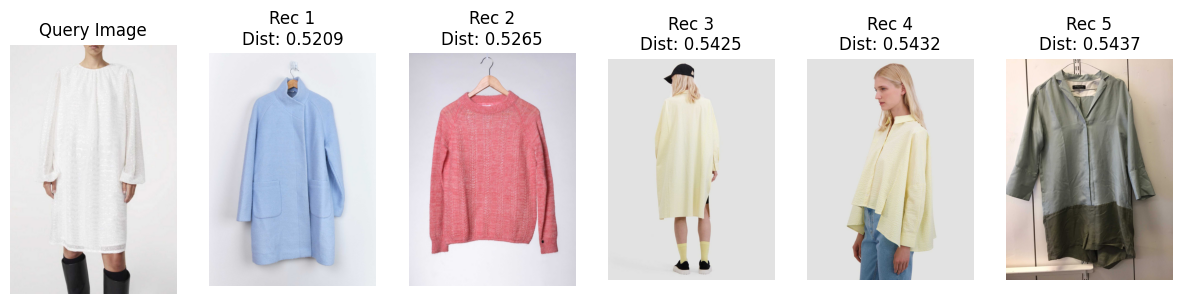

In [25]:
#test in report 6223 4322 1969 5133 9577

# Dự đoán trên tập test
random_image_index = random.randint(0, len(test_files) - 1)
# print(random_image_index)
random_image_index  = 5133
query_embedding = X_test[random_image_index]

recommended_indices, distances = faiss_recommender.recommend(query_embedding, top_k=5)

# Hiển thị kết quả
ImagePlotter.plot_images(train_files, test_files, recommended_indices, distances, random_image_index, image_dir, top_k=5)

## Đối với ảnh tùy chọn

Processing new image and finding similar items...
13
Query image: 3.jpg

Recommended images (sorted by distance):
1. d4e4159c96da4e3eb4268b9c2e6e6676.jpg - Distance: 0.6055
2. d1796d6d734541f9a48861bad7f63c46.jpg - Distance: 0.6450
3. 6fce2c9f0cd04fdcaecca3c2a5ba0eae.jpg - Distance: 0.6623
4. 123c598ffc8143ebbf838a198f864a08.jpg - Distance: 0.6625
5. 95d776510043469d918e927c815e91bc.jpg - Distance: 0.6628
6. 91102d9a29064f0f88f8265e89e7b2fe.jpg - Distance: 0.6663
7. a0c7498404e1f71a.jpg - Distance: 0.6665
8. ee0e99fc49ab4c469dfe050385b5c919.jpg - Distance: 0.6761
9. 21eb7338103e41b397ae0e781a30e75a.jpg - Distance: 0.6761
10. 28800bfc12da41ce97af6e276d76faf6.jpg - Distance: 0.6764


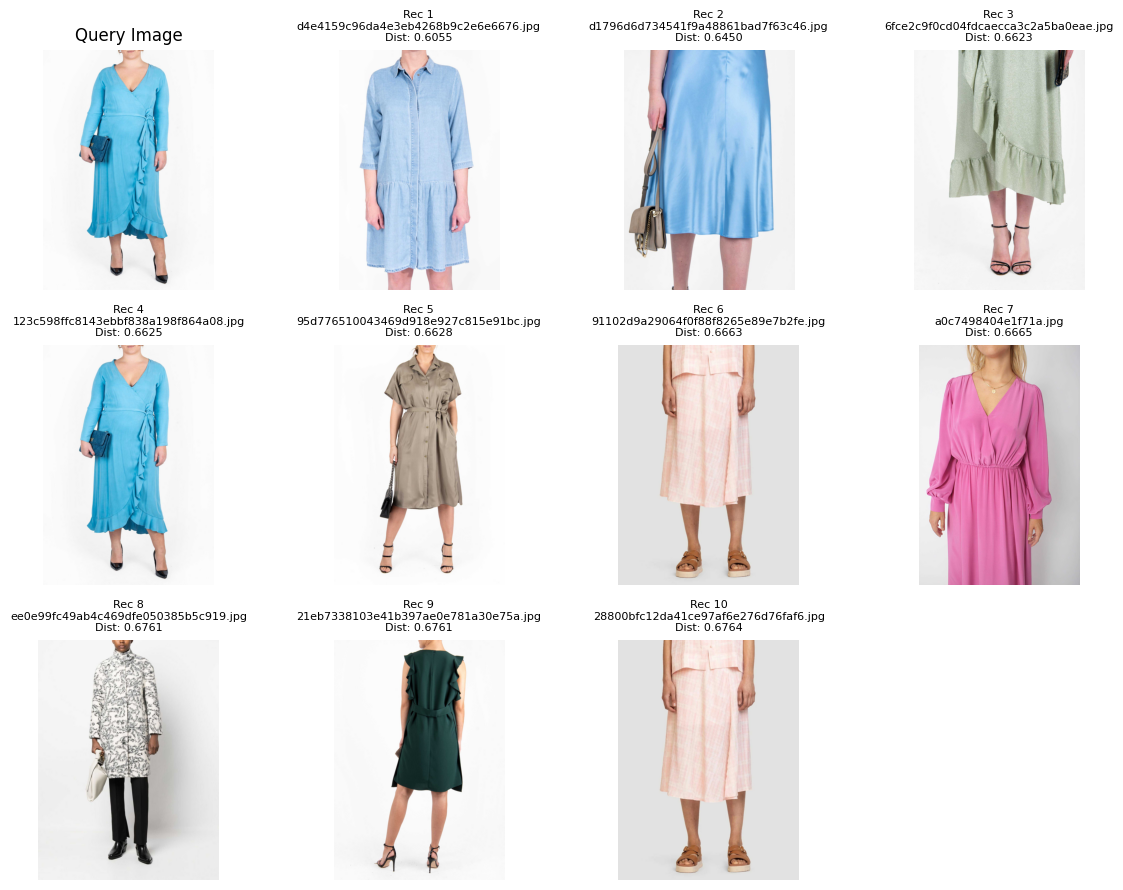

([22023, 36181, 19342, 7458, 25810, 16145, 4979, 8232, 11609, 25840],
 [0.60550153,
  0.6449848,
  0.6622579,
  0.66250026,
  0.66275585,
  0.6663141,
  0.66646016,
  0.6760507,
  0.67606187,
  0.67638934])

In [26]:
#new 8 9 10 11 12
# mobile (ảnh detect cho ra kết quả gần giống cao hơn )
# bị ảnh hưởng ( móc treo người mặc ...)
# Đường dẫn đến ảnh bên ngoài
new_image_path = "/Users/tuanthanh/Documents/KLTN/DuAn/source/Source/rs_img_app/data/testing-rs-system/3.jpg"
print("Processing new image and finding similar items...")
# Gọi hàm để khuyến nghị và hiển thị kết quả
recommend_for_new_image(
    'mobilenet',
    new_image_path,
    faiss_recommender,
    train_files,
    image_dir,
    top_k=10
)

# Evalute

In [27]:

def precision_at_k(relevant, recommended, k):
    """
    Tính Precision@k.
    :param relevant: Danh sách các mục liên quan thực sự.
    :param recommended: Danh sách các mục được khuyến nghị.
    :param k: Số lượng mục trong top-k.
    :return: Precision@k.
    """
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    recommended_set = set(recommended_k)
    return len(relevant_set.intersection(recommended_set)) / k

def recall_at_k(relevant, recommended, k):
    """
    Tính Recall@k.
    :param relevant: Danh sách các mục liên quan thực sự.
    :param recommended: Danh sách các mục được khuyến nghị.
    :param k: Số lượng mục trong top-k.
    :return: Recall@k.
    """
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    recommended_set = set(recommended_k)
    return len(relevant_set.intersection(recommended_set)) / len(relevant) if len(relevant) > 0 else 0

def ndcg_at_k(relevant, recommended, k):
    """
    Tính NDCG@k.
    :param relevant: Danh sách các mục liên quan thực sự.
    :param recommended: Danh sách các mục được khuyến nghị.
    :param k: Số lượng mục trong top-k.
    :return: NDCG@k.
    """
    def dcg_at_k(recommended, relevant, k):
        dcg = 0.0
        for i, item in enumerate(recommended[:k]):
            if item in relevant:
                dcg += 1.0 / np.log2(i + 2)  # i + 2 vì log2(1) = 0
        return dcg

    def idcg_at_k(relevant, k):
        idcg = 0.0
        for i in range(min(len(relevant), k)):
            idcg += 1.0 / np.log2(i + 2)
        return idcg

    dcg = dcg_at_k(recommended, relevant, k)
    idcg = idcg_at_k(relevant, k)
    return dcg / idcg if idcg > 0 else 0

def hit_ratio_at_k(relevant, recommended, k):
    """
    Tính Hit Ratio@k.
    :param relevant: Danh sách các mục liên quan thực sự.
    :param recommended: Danh sách các mục được khuyến nghị.
    :param k: Số lượng mục trong top-k.
    :return: Hit Ratio@k.
    """
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    recommended_set = set(recommended_k)
    return 1 if len(relevant_set.intersection(recommended_set)) > 0 else 0

def mrr_at_k(relevant, recommended, k):
    """
    Tính MRR@k.
    :param relevant: Danh sách các mục liên quan thực sự.
    :param recommended: Danh sách các mục được khuyến nghị.
    :param k: Số lượng mục trong top-k.
    :return: MRR@k.
    """
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            return 1.0 / (i + 1)
    return 0.0

In [28]:
# Ví dụ dữ liệu
relevant = [1, 3, 5]  # Các mục liên quan thực sự
recommended = [1, 2, 3, 4, 5, 6 , 7 , 8 , 9 , 10]  # Các mục được khuyến nghị
k = 10  # Top-3

# Tính các chỉ số
precision = precision_at_k(relevant, recommended, k)
recall = recall_at_k(relevant, recommended, k)
ndcg = ndcg_at_k(relevant, recommended, k)
hit_ratio = hit_ratio_at_k(relevant, recommended, k)
mrr = mrr_at_k(relevant, recommended, k)

print(f"Precision@{k}: {precision}")
print(f"Recall@{k}: {recall}")
print(f"NDCG@{k}: {ndcg}")
print(f"Hit Ratio@{k}: {hit_ratio}")
print(f"MRR@{k}: {mrr}")

Precision@10: 0.3
Recall@10: 1.0
NDCG@10: 0.8854598815714874
Hit Ratio@10: 1
MRR@10: 1.0


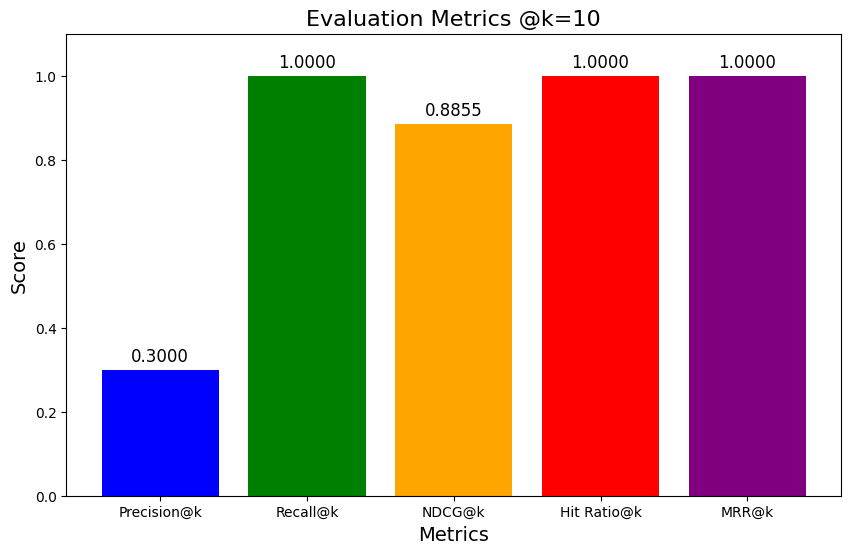

In [29]:

# Dữ liệu để vẽ biểu đồ
metrics = {
    "Precision@k": precision,
    "Recall@k": recall,
    "NDCG@k": ndcg,
    "Hit Ratio@k": hit_ratio,
    "MRR@k": mrr
}

# Tên các chỉ số và giá trị tương ứng
labels = list(metrics.keys())
values = list(metrics.values())

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'green', 'orange', 'red', 'purple'])

# Thêm tiêu đề và nhãn
plt.title(f"Evaluation Metrics @k={k}", fontsize=16)
plt.xlabel("Metrics", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.ylim(0, 1.1)  # Giới hạn trục y từ 0 đến 1.1

# Hiển thị giá trị trên mỗi cột
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f"{value:.4f}", ha='center', fontsize=12)

# Hiển thị biểu đồ
plt.show()

# Application

In [30]:
# !pip3 install --upgrade pyngrok
# !pip3 install flask flask_cors


In [31]:
import os

# Tạo một thư mục mới trong /kaggle/working/
new_dir = "/Users/tuanthanh/Documents/KLTN/DuAn/source/Source/rs_img_app/templates"
os.makedirs(new_dir, exist_ok=True)

# Kiểm tra xem thư mục đã được tạo chưa
print(os.listdir("/Users/tuanthanh/Documents/KLTN/DuAn/source/Source/working/"))

['templates']


In [32]:
import shutil

# Đường dẫn file trong dataset (chỉ đọc)
dataset_file = "/Users/tuanthanh/Documents/KLTN/DuAn/source/Source/rs_img_app/templates/index.html"

# Đường dẫn đến /kaggle/working/
working_file = "/Users/tuanthanh/Documents/KLTN/DuAn/source/Source/working/templates"

# Sao chép file
shutil.copy(dataset_file, working_file)

print(f"✅ Đã sao chép {dataset_file} vào {working_file}")


✅ Đã sao chép /Users/tuanthanh/Documents/KLTN/DuAn/source/Source/rs_img_app/templates/index.html vào /Users/tuanthanh/Documents/KLTN/DuAn/source/Source/working/templates


In [33]:
import os

print("📂 Danh sách file trong /kaggle/working/:")
print(os.listdir("/Users/tuanthanh/Documents/KLTN/DuAn/source/Source/working/templates"))


📂 Danh sách file trong /kaggle/working/:
['index.html']


In [34]:


from flask import Flask, request, render_template, send_file, url_for, redirect , jsonify ,send_from_directory
from werkzeug.utils import secure_filename
import tempfile
from pyngrok import ngrok , conf
import time
import sys
import logging
from flask_cors import CORS

In [35]:
# # # Cấu hình cụ thể cho pyngrok
conf.PyngrokConfig.monitor_thread_stdout_encoding = "utf-8"

# # # Tắt logging của pyngrok để tránh lỗi encoding
logging.getLogger("werkzeug").setLevel(logging.ERROR)
logging.getLogger("pyngrok").setLevel(logging.ERROR)



In [36]:
# 2. Cấu hình authtoken
ngrok.set_auth_token('2eZulRi5AwdqoysGJEy4ljoWMeM_7EuMryCoJkuWXz5QwibRS')  # Thay YOUR_AUTH_TOKEN_HERE bằng token của bạn

In [37]:
app = Flask(__name__)
# Áp dụng CORS cho toàn bộ ứng dụng
CORS(app)

app.config['JSON_AS_ASCII'] = False
app.config['ENCODING'] = 'utf-8'

app.config['MAX_CONTENT_LENGTH'] = 100 * 1024 * 1024  # 100MB max-length
app.config['SEND_FILE_MAX_AGE_DEFAULT'] = 0



In [38]:



# Configuration
UPLOAD_FOLDER = 'static/uploads'
RESULT_FOLDER = 'static/results'
IMAGES_FOLDER = 'static/images'
ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}

# Ensure all required folders exist
for folder in [UPLOAD_FOLDER, RESULT_FOLDER, IMAGES_FOLDER]:
    os.makedirs(folder, exist_ok=True)

app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
app.config['RESULT_FOLDER'] = RESULT_FOLDER
app.config['IMAGES_FOLDER'] = IMAGES_FOLDER

def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS


In [39]:
##App Route

from asyncio.log import logger


@app.route('/')
def index():
    return render_template('index.html')

@app.route('/upload', methods=['POST'])
def upload_file():
    if 'file' not in request.files:
        return jsonify({'error': 'Không tìm thấy file'}), 400

    file = request.files['file']
    if file.filename == '':
        return jsonify({'error': 'Chưa chọn file'}), 400

    if not allowed_file(file.filename):
        return jsonify({'error': 'Loại file không được hỗ trợ'}), 400

    # Lấy giá trị k từ form
    k = int(request.form.get('k', 5))  # Mặc định là 5 nếu không có giá trị
    # Giới hạn k trong khoảng hợp lý
    k = min(max(1, k), 20)  # Giới hạn k từ 1 đến 20

    try:
        filename = secure_filename(file.filename)
        unique_filename = f"{int(time.time())}_{filename}"
        file_path = os.path.join(app.config['UPLOAD_FOLDER'], unique_filename)
        
        os.makedirs(app.config['UPLOAD_FOLDER'], exist_ok=True)
        file.save(file_path)
        
        embed_dir = "/Users/tuanthanh/Documents/KLTN/DuAn/source/Source/rs_img_app/data/embeddings_MBNV2_full"
        image_dir = "/Users/tuanthanh/Documents/KLTN/DuAn/source/Source/rs_img_app/detect_YOLOv5s/images"

        # Sử dụng k từ input của người dùng
        recommendations = recommend_for_new_image(
            model_type="mobilenet",
            image_path=file_path,
            faiss_recommender=faiss_recommender,
            train_files=train_files,
            embed_dir_images=image_dir,
            top_k=k  # Sử dụng k ở đây
        )
        
        if recommendations is None:
            return jsonify({'error': 'Không thể tạo recommendations'}), 500
        
        recommended_indices, distances = recommendations
        
        result_images = []
        for idx, (rec_idx, distance) in enumerate(zip(recommended_indices, distances)):
            rec_filename = train_files[rec_idx].replace("picture.", "").replace(".npy", ".jpg")
            image_path = os.path.join(image_dir, rec_filename)
            
            if not os.path.exists(image_path):
                continue
                
            static_image_path = os.path.join(app.static_folder, 'images', rec_filename)
            if not os.path.exists(static_image_path):
                os.makedirs(os.path.dirname(static_image_path), exist_ok=True)
                shutil.copy2(image_path, static_image_path)
            
            result_images.append({
                'filename': rec_filename,
                'distance': float(distance),
                'path': f'/static/images/{rec_filename}'
            })

        query_image_url = f'/static/uploads/{unique_filename}'

        return jsonify({
            'query_image': query_image_url,
            'recommendations': result_images
        })

    except Exception as e:
        logger.error(f"Error occurred: {str(e)}", exc_info=True)
        return jsonify({'error': str(e)}), 500




Public URL: NgrokTunnel: "https://d678-2402-800-6314-903b-3108-499-b4d3-f380.ngrok-free.app" -> "http://localhost:5050"
 * Serving Flask app '__main__'
 * Debug mode: off
5
Query image: 1745227874_10.jpg

Recommended images (sorted by distance):
1. 19d63ec76e114f568505c7bc416031f4.jpg - Distance: 0.6663
2. 5fc5be501e1f4a689c4b05bffd809d1e.jpg - Distance: 0.6880
3. a114979c6aeb43a79f46ed405f619d46.jpg - Distance: 0.6990
4. b846ce53609d4780b31628ea928ec013.jpg - Distance: 0.7213
5. 49647237b2874cb4965083d5b7eb6080.jpg - Distance: 0.7234


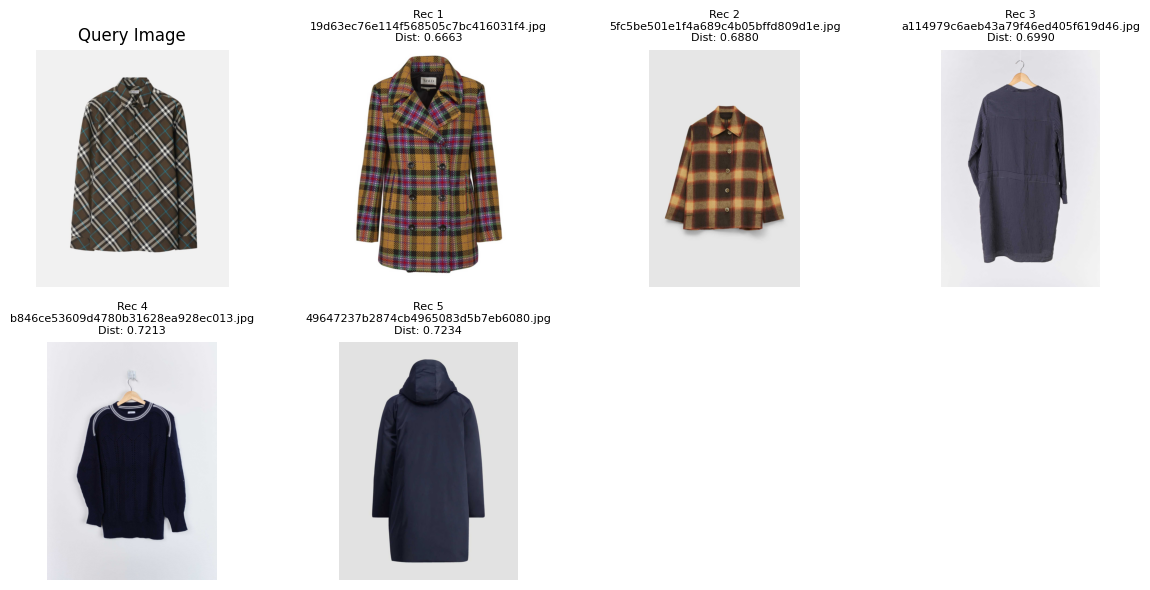

2
Query image: 1745227929_2.jpg

Recommended images (sorted by distance):
1. 8a27cd701ff74dd4b48b364f115dcbba.jpg - Distance: 0.6274
2. c7b9e51cb4134f10b0d004717c0233d3.jpg - Distance: 0.6531


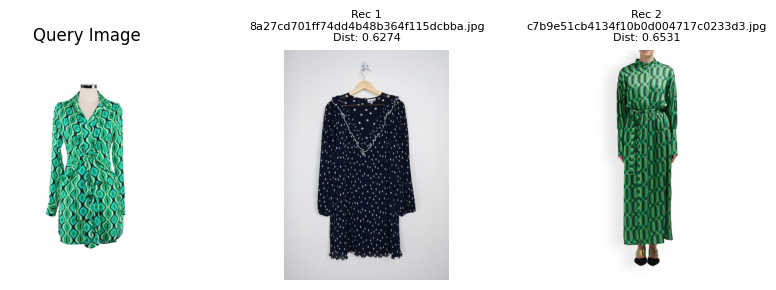

In [ ]:

try:
    public_url = ngrok.connect(5050)
    print('Public URL:', public_url)
except Exception as e:
    print('tunnel create error:', str(e))
    ngrok.kill()
    public_url = ngrok.connect(5050)
    print('Public URL:', public_url)

if __name__ == '__main__':
    app.run(host='localhost', port=5050)